# Oxford IIIT Pet Database

This is a database of images of pets with associated trimap segmentation of the pet and a bounding box around the head of the pet. The dataset consists of 37 categories of pets including cats and dogs. In the segmentation class 1 is a pixel belonging to the pet, class 2 is a pixel bordering the pet, and class 3 is a pixel not belonging to or bordering the pet. This loosely follows <a href="https://www.tensorflow.org/tutorials/images/segmentation">this</a> tutorial.

## Imports

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

plt.style.use('dark_background')

## Helper Functions

In [6]:
def plot_training_metrics(history):
    '''
    Takes a history object generated along with model training and plots
    selected training metrics.
    '''
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.suptitle('Model Training')
    plt.show()

def save_best_model(model, test_ds, filename, save_traces=True):
    '''
    Compares the performance of a saved model stored at filename with the provided model on
    the provided test dataset. If the provided model performs better than the saved model
    the provided model is saved to filename, overwriting the previously saved model. If
    no saved model is present at filename then the provided model is saved to filename
    '''
    try:
        saved_model = tf.keras.models.load_model(filename)
    except:
        saved_model = None

    if saved_model:
        print('Saved Model Evaluation:')
        saved_model_metrics = saved_model.evaluate(test_ds, return_dict=True)
        print('New Model Evaluation:')
        new_model_metrics = model.evaluate(test_ds, return_dict=True)
        if new_model_metrics['loss'] < saved_model_metrics['loss']:
            model.save(filename, save_traces=save_traces)
    else:
        print('New Model Evaluation:')
        new_model_metrics = model.evaluate(test_ds)
        model.save(filename, save_traces=save_traces)

## Loading and Processing the Dataset

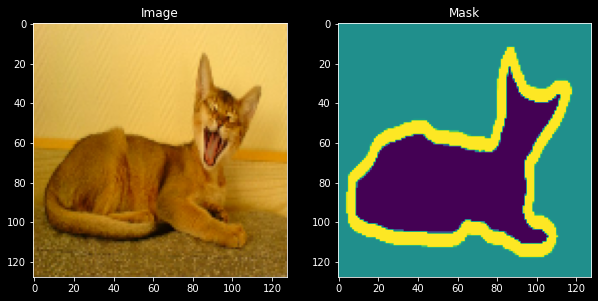

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
shuffle_buffer = 1000

(test_ds, train_ds, validation_ds), ds_info = tfds.load('oxford_iiit_pet', split=['test', 'train[:80%]', 'train[80%:]'], with_info=True)

def flip_image_and_mask(image, mask):
    seed = tf.random.uniform([2], maxval=128, dtype=tf.int32)
    image = tf.image.stateless_random_flip_left_right(image, seed=seed)
    mask = tf.image.stateless_random_flip_left_right(mask, seed=seed)
    return image, mask

def process_data_entry(entry):
    image = tf.image.resize(entry['image'], (128, 128))
    mask = tf.image.resize(entry['segmentation_mask'], (128, 128))
    image = tf.cast(image, tf.float32)/255
    mask -= 1
    return image, mask

def process_ds(ds):
    ds = ds.map(process_data_entry, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

def process_train_ds(train_ds):
    '''
    This is different so augmentation is only applied to the training data
    '''
    train_ds = train_ds.map(process_data_entry, num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.map(flip_image_and_mask, num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.shuffle(shuffle_buffer)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(AUTOTUNE)
    return train_ds

test_ds = process_ds(test_ds)
train_ds = process_train_ds(train_ds)
validation_ds = process_ds(validation_ds)

# Showing a sample image and mask
for batch in train_ds.take(1):
    image, mask = batch[0][0], batch[1][0]
    plt.figure(figsize=(10, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.title('Image')
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
    plt.title('Mask')
    plt.show()

## Building the Model

In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = [
    'block_1_expand_relu', # 64 x 64
    'block_3_expand_relu', # 32 x 32
    'block_6_expand_relu', # 16 x 16
    'block_13_expand_relu', # 8 x 8
    'block_16_project' # 4 x 4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0, 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(
        filters,
        size,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        use_bias=False
    ))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),
    upsample(256, 3),
    upsample(128, 3),
    upsample(64, 3)
]

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels,
        kernel_size=3,
        strides=2,
        padding='same'
    )

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Training the Model

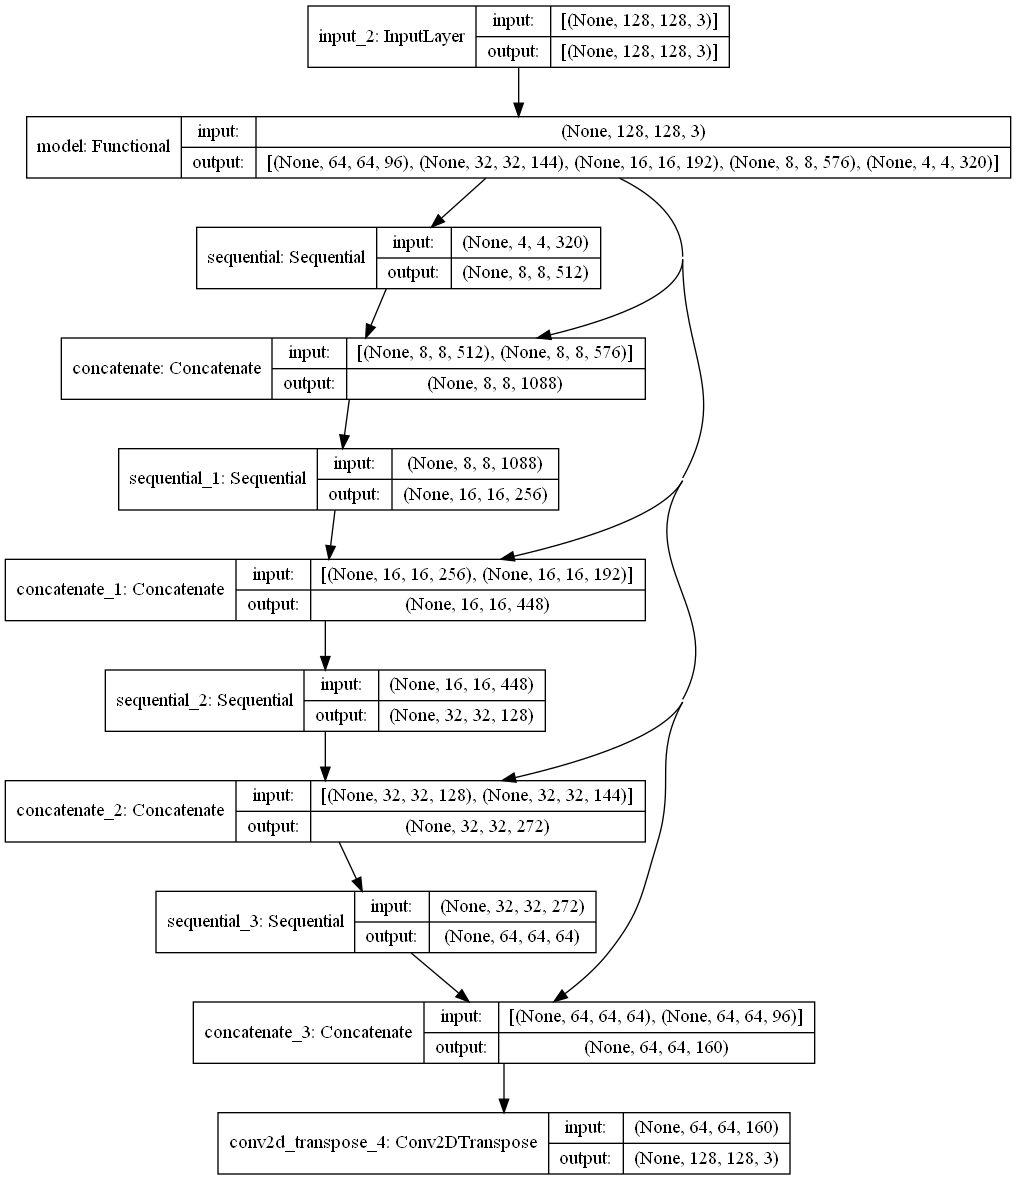

In [8]:
OUTPUT_CLASSES = 3

# Best Model
# model = unet_model(output_channels=OUTPUT_CLASSES)
# model.compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
#     optimizer=tf.keras.optimizers.Adam()
# )

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(1e-4)
)
tf.keras.utils.plot_model(model, show_shapes=True, to_file='models\\unet.png')

In [9]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='min',
    monitor='val_loss',
    patience=3
)
history = model.fit(train_ds, callbacks=[early_stopping_callback], epochs=100, validation_data=validation_ds)

Epoch 1/100
92/92 [==============================] - 20s 103ms/step - loss: 0.8670 - sparse_categorical_accuracy: 0.6386 - val_loss: 0.7031 - val_sparse_categorical_accuracy: 0.7388
Epoch 2/100
92/92 [==============================] - 9s 94ms/step - loss: 0.4738 - sparse_categorical_accuracy: 0.8332 - val_loss: 0.4996 - val_sparse_categorical_accuracy: 0.8204
Epoch 3/100
92/92 [==============================] - 9s 96ms/step - loss: 0.3809 - sparse_categorical_accuracy: 0.8584 - val_loss: 0.4198 - val_sparse_categorical_accuracy: 0.8366
Epoch 4/100
92/92 [==============================] - 9s 94ms/step - loss: 0.3361 - sparse_categorical_accuracy: 0.8708 - val_loss: 0.3554 - val_sparse_categorical_accuracy: 0.8626
Epoch 5/100
92/92 [==============================] - 9s 93ms/step - loss: 0.3104 - sparse_categorical_accuracy: 0.8787 - val_loss: 0.3216 - val_sparse_categorical_accuracy: 0.8715
Epoch 6/100
92/92 [==============================] - 9s 95ms/step - loss: 0.2905 - sparse_categori

## Plotting Training Metrics and Saving the Best Model

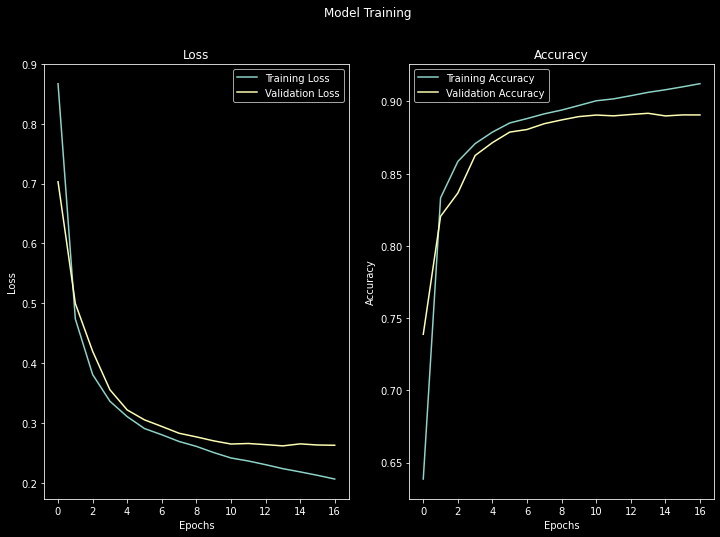

Saved Model Evaluation:
115/115 [==============================] - 7s 48ms/step - loss: 0.2760 - accuracy: 0.8935
New Model Evaluation:
115/115 [==============================] - 5s 42ms/step - loss: 0.2798 - sparse_categorical_accuracy: 0.8878


In [10]:
plot_training_metrics(history)
save_best_model(model, test_ds, 'models\\UNet')

## Showing Predictions

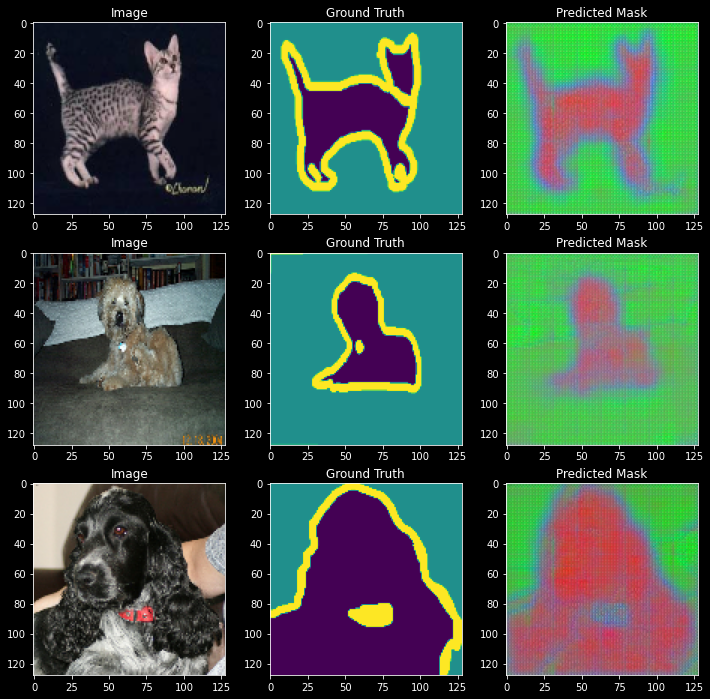

In [11]:
examples_to_show = 3

best_model = tf.keras.models.load_model('models\\UNet')
for examples, labels in test_ds.take(1):
    plt.figure(figsize=(4*examples_to_show, 12))
    for i in range(examples_to_show):
        image = examples[i]
        true_mask = labels[i]
        predicted_mask = best_model(tf.expand_dims(image, 0))[0,:,:,:]
        plt.subplot(examples_to_show, 3, 3*i+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
        plt.title('Image')
        plt.subplot(examples_to_show, 3, 3*i+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(true_mask))
        plt.title('Ground Truth')
        plt.subplot(examples_to_show, 3, 3*i+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(predicted_mask))
        plt.title('Predicted Mask')
    plt.show()

## Accounting for Class Imbalances in the Dataset

### Processing the Dataset

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
shuffle_buffer = 1000

(test_ds, train_ds, validation_ds), ds_info = tfds.load('oxford_iiit_pet', split=['test', 'train[:80%]', 'train[80%:]'], with_info=True)

def flip_image_and_mask(image, mask, weights):
    seed = tf.random.uniform([2], maxval=128, dtype=tf.int32)
    image = tf.image.stateless_random_flip_left_right(image, seed=seed)
    mask = tf.image.stateless_random_flip_left_right(mask, seed=seed)
    return image, mask, weights

def process_data_entry(entry):
    image = tf.image.resize(entry['image'], (128, 128))
    mask = tf.image.resize(entry['segmentation_mask'], (128, 128))
    image = tf.cast(image, tf.float32)/255
    mask -= 1
    class_weights = tf.constant([2, 2, 1])
    class_weights /= tf.reduce_sum(class_weights)
    weights = tf.gather(class_weights, indices=tf.cast(mask, tf.int32))
    return image, mask, weights

def process_ds(ds):
    ds = ds.map(process_data_entry, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

def process_train_ds(train_ds):
    '''
    This is different so augmentation is only applied to the training data
    '''
    train_ds = train_ds.map(process_data_entry, num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.map(flip_image_and_mask, num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.shuffle(shuffle_buffer)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(AUTOTUNE)
    return train_ds

test_ds = process_ds(test_ds)
train_ds = process_train_ds(train_ds)
validation_ds = process_ds(validation_ds)

## Training the Model

In [13]:
OUTPUT_CLASSES = 3

# Best Model
# model = unet_model(output_channels=OUTPUT_CLASSES)
# model.compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
#     optimizer=tf.keras.optimizers.Adam()
# )

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(1e-4)
)

In [14]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='min',
    monitor='val_loss',
    patience=3
)
history = model.fit(train_ds, callbacks=[early_stopping_callback], epochs=100, validation_data=validation_ds)

Epoch 1/100
92/92 [==============================] - 12s 103ms/step - loss: 0.2799 - sparse_categorical_accuracy: 0.6925 - val_loss: 0.1697 - val_sparse_categorical_accuracy: 0.8350
Epoch 2/100
92/92 [==============================] - 9s 95ms/step - loss: 0.1416 - sparse_categorical_accuracy: 0.8626 - val_loss: 0.1233 - val_sparse_categorical_accuracy: 0.8549
Epoch 3/100
92/92 [==============================] - 10s 96ms/step - loss: 0.1081 - sparse_categorical_accuracy: 0.8807 - val_loss: 0.1035 - val_sparse_categorical_accuracy: 0.8685
Epoch 4/100
92/92 [==============================] - 10s 96ms/step - loss: 0.0919 - sparse_categorical_accuracy: 0.8925 - val_loss: 0.0980 - val_sparse_categorical_accuracy: 0.8727
Epoch 5/100
92/92 [==============================] - 10s 97ms/step - loss: 0.0826 - sparse_categorical_accuracy: 0.9013 - val_loss: 0.0899 - val_sparse_categorical_accuracy: 0.8820
Epoch 6/100
92/92 [==============================] - 10s 97ms/step - loss: 0.0761 - sparse_cate

### Plotting Training Metrics and Saving the Best Model

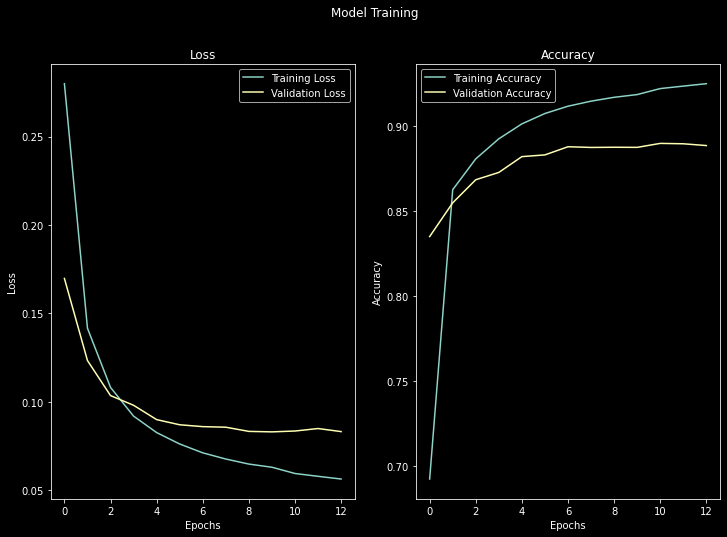

New Model Evaluation:
115/115 [==============================] - 6s 45ms/step - loss: 0.0873 - sparse_categorical_accuracy: 0.8850


C:\Users\smf24\miniconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models\WeightedUNet\assets


INFO:tensorflow:Assets written to: models\WeightedUNet\assets


In [15]:
plot_training_metrics(history)
save_best_model(model, test_ds, 'models\\WeightedUNet')

### Showing Sample Predictions

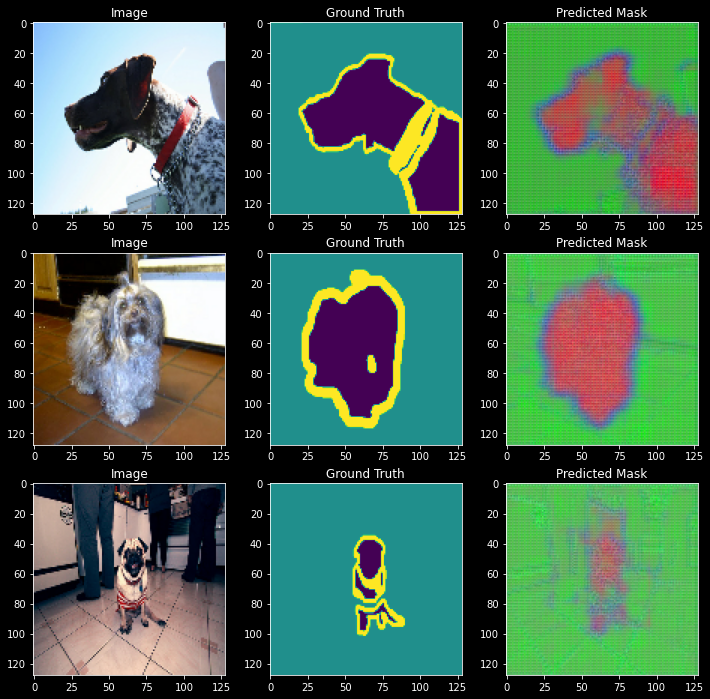

In [19]:
examples_to_show = 3

best_model = tf.keras.models.load_model('models\\WeightedUNet')
for examples, labels, weights in test_ds.take(1):
    plt.figure(figsize=(4*examples_to_show, 12))
    for i in range(examples_to_show):
        image = examples[i]
        true_mask = labels[i]
        predicted_mask = best_model(tf.expand_dims(image, 0))[0,:,:,:]
        plt.subplot(examples_to_show, 3, 3*i+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
        plt.title('Image')
        plt.subplot(examples_to_show, 3, 3*i+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(true_mask))
        plt.title('Ground Truth')
        plt.subplot(examples_to_show, 3, 3*i+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(predicted_mask))
        plt.title('Predicted Mask')
    plt.show()

Accounting for the class imbalance in the dataset seems to make a significant difference in the quality of the final predictions.